In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/dlabdata1/lugeon/websites_dmoz_multi.gz', compression='gzip')
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,uid,url,lang,lang_id,cat0
0,184,www.delphipraxis.net,Deutsch,de,Computers
1,263,www.central-it.de,Deutsch,de,Computers
2,731,www.aus-wandern.de,Deutsch,de,Computers
3,1072,blog.cvjm-nuernberg.de,Deutsch,de,Computers
4,1101,www.ges-training.de,Deutsch,de,Computers
...,...,...,...,...,...
1025176,2488203,www.stompin-ground.com,English,en,Arts
1025177,2488226,www.quarrypark.co.uk,English,en,Sports
1025178,2488230,www.sugarcreekwines.com,English,en,Recreation
1025179,2488233,www.aera.net,English,en,Reference


In [5]:
def clean_url(url):
    url = re.sub(r"www.|http://|https://|-|_", '', url)
    return url.split('.')[0]

In [6]:
def compute_ngram(s, n):
    return [s[i:i+n] for i in range(0, len(s)-n+1)]



def concat_ngrams(s, ns):
    l = []
    for n in ns:
        l += compute_ngram(s, n)
    return list(set(l))

In [7]:
df_en = df[df.lang_id == 'en']
df_en.cat0.value_counts()

Business      148144
Society        82079
Arts           66721
Shopping       54062
Recreation     46095
Computers      45194
Sports         34890
Science        28138
Health         24218
Reference      21663
Games          10246
Home            6952
News            3696
Name: cat0, dtype: int64

In [17]:
df_bal = pd.DataFrame()
nsamples = 5_000
for cat in df_en.cat0.unique():
    df_cat = df_en[df_en.cat0 == cat]
    df_cat = df_cat.sample(min(df_cat.shape[0], nsamples), random_state=42)
    df_bal = pd.concat((df_bal, df_cat))

In [18]:
df_bal['clean_url'] = df_bal.apply(lambda row: clean_url(row.url), axis=1)

In [19]:
df_bal

,uid,url,lang,lang_id,cat0,clean_url
934747,2094851,www.gyrosystem.co.uk,English,en,Computers,gyrosystem
888399,1892699,www.capegraphics.com,English,en,Computers,capegraphics
610948,691456,jsutils.sourceforge.net,English,en,Computers,jsutils
514655,267211,www.gwei.org,English,en,Computers,gwei
596136,624824,www.simplewire.com,English,en,Computers,simplewire
...,...,...,...,...,...,...
822571,1606581,www.cyber-aspect.com,English,en,Home,cyberaspect
791096,1470684,bbqguyblog.blogspot.com,English,en,Home,bbqguyblog
511278,252365,bighappyfamily.blogspot.com,English,en,Home,bighappyfamily
694067,1053553,www.carnivorousplants.org,English,en,Home,carnivorousplants


In [20]:
ns = range(3, 8) # from 3 to 7
df_bal['ngrams'] = df_bal.apply(lambda row: concat_ngrams(row.clean_url, ns), axis=1)

In [21]:
categories = df_bal.cat0.unique()

def categorize(c):
    return categories.tolist().index(c)

In [22]:
df_bal['catno'] = df_bal.apply(lambda row: categorize(row.cat0), axis=1)

In [23]:
ix = np.arange(df_bal.shape[0])
np.random.shuffle(ix)
sep = int((1 - 0.1) * df_bal.shape[0])
train = df_bal.iloc[ix[:sep]]
test = df_bal.iloc[ix[sep:]]

In [24]:
train.cat0.value_counts()

Recreation    4537
Society       4529
Arts          4520
Shopping      4518
Science       4505
Sports        4503
Home          4496
Business      4492
Computers     4486
Reference     4473
Games         4468
Health        4466
News          3333
Name: cat0, dtype: int64

In [25]:
test.cat0.value_counts()

Health        534
Games         532
Reference     527
Computers     514
Business      508
Home          504
Sports        497
Science       495
Shopping      482
Arts          480
Society       471
Recreation    463
News          363
Name: cat0, dtype: int64

In [26]:
train_bycat = train[['cat0', 'ngrams']].groupby('cat0').agg(lambda col: [s for l in col for s in l])

In [27]:
def top_ngrams(l):
    return pd.Series(l).value_counts().to_dict()

In [28]:
train_bycat['top_ngrams_count'] = train_bycat.apply(lambda row: top_ngrams(row.ngrams), axis=1)

In [29]:
def reduce_ngrams(ngrams_dict, nb_rep_ngrams):
    red = set()
    for s in ngrams_dict.keys(): # candidate
        valid = True
        init_count = ngrams_dict[s]
        for t in list(ngrams_dict.keys()): # superstring
            if len(t) > len(s): # longest substring
                if s in t: # if there is a super-string in the ngrams
                    if (init_count - ngrams_dict[t])/init_count <= 0.3: # and that there count rapport is less than 0.6
                        s = t # discard substring
        if valid:
            red.add(s)
        if len(red) == nb_rep_ngrams:
            break
                
    return red

In [30]:
nb_rep_ngrams = 50

train_bycat['rep_ngrams'] = train_bycat.apply(lambda row: reduce_ngrams(row.top_ngrams_count, nb_rep_ngrams), axis=1)

In [31]:
train_bycat

,ngrams,top_ngrams_count,rep_ngrams
cat0,,,
Arts,"[udrey, udr, unt, audr, dreybu, eyb, reybunt, ...","{'the': 249, 'art': 248, 'and': 228, 'ing': 18...","{con, ang, lin, sto, eat, tor, tre, car, alle,..."
Business,"[ircha, hartert, rte, rteam, irc, rtea, terte,...","{'ing': 309, 'ion': 194, 'ent': 157, 'ter': 15...","{ati, int, che, nte, con, lin, pro, tec, all, ..."
Computers,"[sana, sanadg, anadg, nadger, susanad, usana, ...","{'ing': 194, 'web': 192, 'ion': 179, 'oft': 17...","{int, media, oftware, nte, con, age, lin, sys,..."
Games,"[gmons, nster, onst, monster, monste, ons, gmo...","{'gam': 415, 'ame': 371, 'game': 343, 'ing': 2...","{min, con, der, lin, mer, all, net, ack, ide, ..."
Health,"[lymp, oru, omaf, omafor, phomaf, afo, pho, mp...","{'ing': 255, 'lin': 242, 'ent': 227, 'ter': 20...","{tic, cent, lin, ospital, ical, medi, ons, and..."
Home,"[helo, lyplant, elovel, ants, elypla, lants, v...","{'ing': 398, 'ard': 296, 'the': 269, 'den': 26...","{nan, ati, che, con, ani, lin, mer, ood, car, ..."
News,"[ehrdir, rdirect, rdi, recto, hehrdi, ehrdi, d...","{'new': 502, 'ews': 486, 'news': 478, 'the': 3...","{media, ount, photo, der, star, sto, line, ron..."
Recreation,"[ailarou, ndbirmi, ngh, ngham, rmingha, undbir...","{'ing': 350, 'ers': 296, 'ine': 288, 'ter': 22...","{der, unt, lin, camp, ave, all, ail, ree, vin,..."
Reference,"[obadg, gobadge, obadger, badge, badgers, badg...","{'mus': 184, 'use': 183, 'ing': 178, 'muse': 1...","{stud, ari, che, cent, librar, uni, athleti, l..."


In [32]:
all_rep_grams = np.unique([gram for gramlist in train_bycat.rep_ngrams for gram in gramlist])
all_rep_grams.shape

(288,)

In [33]:
all_rep_grams

array(['ach', 'ack', 'adopt', 'age', 'ail', 'all', 'alle', 'ame', 'anc',
       'ance', 'and', 'ang', 'ani', 'animal', 'ann', 'ant', 'ara', 'arat',
       'ard', 'are', 'ari', 'art', 'ass', 'ast', 'ate', 'athleti', 'ati',
       'ation', 'ave', 'ball', 'band', 'baptist', 'bio', 'bridge', 'cal',
       'camp', 'car', 'care', 'casino', 'cent', 'center', 'cha', 'che',
       'chem', 'chess', 'chi', 'child', 'cho', 'church', 'cing', 'cke',
       'clan', 'clinic', 'club', 'college', 'com', 'con', 'cook', 'count',
       'county', 'cra', 'cycl', 'daily', 'dan', 'dance', 'der', 'desi',
       'design', 'dio', 'ear', 'eat', 'eco', 'ect', 'ega', 'ell', 'ence',
       'enews', 'ens', 'ent', 'enter', 'era', 'eri', 'ers', 'eschool',
       'esign', 'ess', 'est', 'family', 'farm', 'fish', 'food', 'for',
       'game', 'games', 'gaming', 'garden', 'gen', 'geo', 'golf',
       'golfclu', 'gra', 'group', 'har', 'hea', 'heal', 'health', 'her',
       'herald', 'hin', 'hletics', 'home', 'horse', 'hospi

In [34]:
def encode_repgrams_onehot(s, repgrams):
    onehot = np.array([int(gram in s) for gram in repgrams])
    return onehot

### Clustering

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [36]:
test.reset_index(inplace=True, drop=True)
test

,uid,url,lang,lang_id,cat0,clean_url,ngrams,catno
0,742912,www.myevents.com,English,en,Computers,myevents,"[even, ven, myev, yev, vents, yevent, ents, nt...",0
1,2048342,www.buysellcommunity.com,English,en,Shopping,buysellcommunity,"[buysel, buyse, munit, buysell, sellcom, omm, ...",8
2,87105,www.highmountainweddings.com,English,en,Society,highmountainweddings,"[untainw, ddi, tainwe, ountain, inwe, ghmo, nt...",2
3,491545,www.domdechantwerner.com,English,en,Recreation,domdechantwerner,"[omd, wer, erne, domd, mdech, omdecha, antw, w...",7
4,1455153,www.oregonchai.com,English,en,Shopping,oregonchai,"[gon, nchai, egonch, ore, egon, regonch, regon...",8
...,...,...,...,...,...,...,...,...
6365,291305,www.ecuita.com,English,en,Science,ecuita,"[cui, ecuit, ecuita, uit, cuita, uita, ecu, ec...",5
6366,2195378,foodandthoughts.blogspot.com,English,en,Home,foodandthoughts,"[thoug, odand, oodand, houg, dth, ught, odandt...",12
6367,679353,www.stjohnsprimary.kent.sch.uk,English,en,Society,stjohnsprimary,"[tjohns, primary, nsprim, hns, johnspr, ohnspr...",2
6368,1513115,www.navegantegroup.com,English,en,Games,navegantegroup,"[tegr, anteg, nte, gro, nteg, veg, aveg, egant...",10


In [37]:
test['ngrams_oh'] = test.apply(lambda row: encode_repgrams_onehot(row.clean_url, all_rep_grams), axis=1)

<ipython-input-37-31d22b69adfb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ngrams_oh'] = test.apply(lambda row: encode_repgrams_onehot(row.clean_url, all_rep_grams), axis=1)


In [38]:
test.head(1)

,uid,url,lang,lang_id,cat0,clean_url,ngrams,catno,ngrams_oh
0,742912,www.myevents.com,English,en,Computers,myevents,"[even, ven, myev, yev, vents, yevent, ents, nt...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [39]:
x = np.concatenate(test.ngrams_oh.to_numpy()).ravel()
x = x.reshape(-1, len(all_rep_grams))
x.shape

(6370, 288)

In [40]:
train.cat0.nunique()

13

In [41]:
pca = PCA(n_components=13)
x_pca = pca.fit_transform(x)

In [42]:
x_pca

array([[ 0.03222541,  0.06455295,  0.34337471, ...,  0.01868494,
         0.13503884,  0.10479184],
       [-0.02249899, -0.11925346, -0.01818563, ..., -0.09981399,
         0.04979925, -0.01212225],
       [ 0.00757703,  0.70080708, -0.24726149, ..., -0.10464251,
        -0.04035939, -0.07033636],
       ...,
       [-0.08000398, -0.07353597, -0.01526005, ..., -0.06495671,
        -0.01430877,  0.00405512],
       [ 0.09042123,  0.00945271,  0.32393563, ..., -0.1563707 ,
         0.00104171, -0.03338973],
       [-0.06458515, -0.10055036,  0.00236465, ..., -0.01898395,
         0.00601793,  0.07741125]])

In [49]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x)

In [50]:
x_tsne

array([[ 15.3493805,  45.178913 ],
       [ 52.862415 ,  22.467436 ],
       [ 36.71663  ,  58.53847  ],
       ...,
       [-42.458332 , -13.12736  ],
       [ 68.407455 ,   9.2493305],
       [-23.283401 ,  11.269152 ]], dtype=float32)

<ipython-input-51-09e1fdedd9b4>:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
<ipython-input-51-09e1fdedd9b4>:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


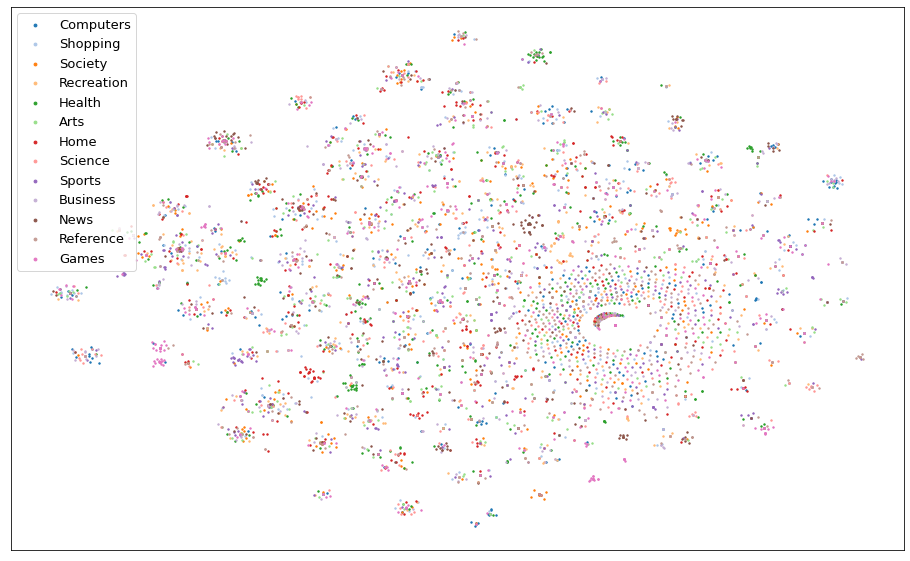

In [51]:
categories = test.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 2
marker = 'o'

fig, ax = plt.subplots(figsize=(16, 10))

n = 0
ncat = len(categories)

for cat in categories:
    ix = test[test.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

#ax.set_xlim([-45,65])
#ax.set_ylim([0,1])

ax.set_xticks([], [])
ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=2, fontsize=13)
plt.plot();

bof...

### Training random classifier

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

In [269]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [378]:
nb_all_ngram = []
fracs = []
train_scores = []
test_scores = []

range_rep_ngrams = [1] + list(range(10, 80, 10))

for nb_rep_ngrams in tqdm(range_rep_ngrams):

    train_bycat['rep_ngrams'] = train_bycat.apply(lambda row: reduce_ngrams(row.top_ngrams_count, nb_rep_ngrams), axis=1)

    all_rep_grams = np.unique([gram for gramlist in train_bycat.rep_ngrams for gram in gramlist])
    
    train['repgrams_oh'] = train.apply(lambda row: encode_repgrams_onehot(row.clean_url, all_rep_grams), axis=1)
    test['repgrams_oh'] = test.apply(lambda row: encode_repgrams_onehot(row.clean_url, all_rep_grams), axis=1)

    no_repgram = (train.repgrams_oh.apply(sum) == 0).value_counts()
    frac_no_repgram = (no_repgram[True] / (no_repgram[True] + no_repgram[False])) # percentage of urls without any rep ngrams
    
    x_train = np.concatenate(train[train.repgrams_oh.apply(sum) != 0].repgrams_oh.to_numpy()).ravel()
    x_train = x_train.reshape(-1, all_rep_grams.shape[0])
    
    x_test = np.concatenate(test[test.repgrams_oh.apply(sum) != 0].repgrams_oh.to_numpy()).ravel()
    x_test = x_test.reshape(-1, all_rep_grams.shape[0])
    
    y_train = train[train.repgrams_oh.apply(sum) != 0].catno.values
    
    y_test = test[test.repgrams_oh.apply(sum) != 0].catno.values

    forest = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
    forest.fit(x_train, y_train)

    train_score = precision_recall_fscore_support(y_train, forest.predict(x_train), average='weighted')
    test_score = precision_recall_fscore_support(y_test, forest.predict(x_test), average='weighted')
    
    nb_all_ngram += [len(all_rep_grams)]
    fracs += [frac_no_repgram]
    train_scores += [train_score]
    test_scores += [test_score]

100%|██████████| 8/8 [07:40<00:00, 57.59s/it]


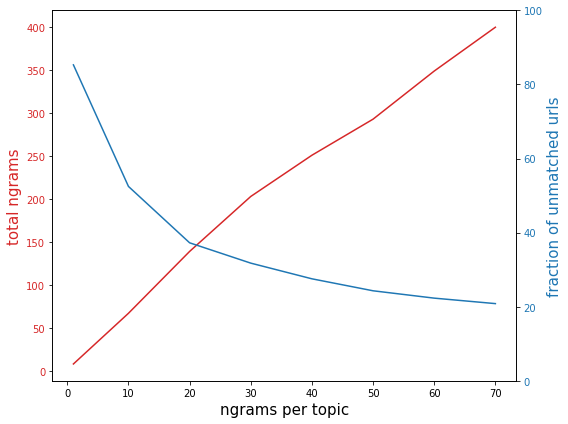

In [379]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('ngrams per topic', size=15)
ax1.set_ylabel('total ngrams', color=color, size=15)
ax1.plot(range_rep_ngrams, nb_all_ngram, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('fraction of unmatched urls', color=color, size=15)  # we already handled the x-label with ax1
ax2.plot(range_rep_ngrams, [100 * f for f in fracs], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,100])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


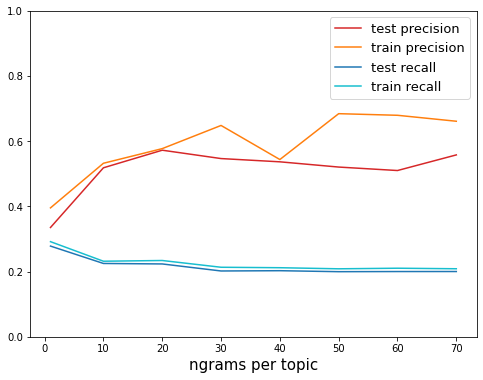

In [380]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel('ngrams per topic', size=15)

ax1.plot(range_rep_ngrams, [s[0] for s in test_scores], color='tab:red', label='test precision')
ax1.plot(range_rep_ngrams, [s[0] for s in train_scores], color='tab:orange', label='train precision')

ax1.plot(range_rep_ngrams, [s[1] for s in test_scores], color='tab:blue', label='test recall')
ax1.plot(range_rep_ngrams, [s[1] for s in train_scores], color='tab:cyan', label='train recall')

ax1.set_ylim([0,1])

plt.legend(fontsize=13)

plt.show()

Best classifier seem to be with 50 most common ngrams and a max depth of 10